In [1]:
import sys
import glob
import pickle
import numpy as np
import re
from datetime import datetime
from music21 import converter, note, chord, stream, instrument

from music21 import converter, note, chord, stream, instrument

from keras import optimizers
from keras.models import Sequential, load_model
from keras.layers import Bidirectional, Dense, Dropout, LSTM, Activation, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard, History, Callback, EarlyStopping
from keras.utils import np_utils

import functions2 as fxn


Using TensorFlow backend.


In [2]:


midi_files = '/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/*.mid'

timestamp = re.sub(r'[-: ]','',str(datetime.now()).split('.')[0])[:-2]
output_name = midi_files.split('/')[-2]
total_epochs = 50
batch_size = 128 # 128 for local; 512 for AWS
sequence_length = 100 # the LSTM RNN will consider this many notes
notes_generated = 500
temperature = 0.9
offset_adj = 0.5

output_tag = '/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/output/{}-{}-'.format(timestamp, output_name)
# sound = instrument.Bagpipes()


def full_execution(midi_files, output_tag, total_epochs, batch_size, sequence_length, temperature, offset_adj):
    # epoch_stops = 1
    # epoch_count = 0
    weight_file = None

    note_file = fxn.convert_midis_to_notes(midi_files, output_tag)

    epochs = total_epochs
    with open(note_file, 'rb') as filepath:
        notes = pickle.load(filepath)
    network_input, network_output, n_patterns, n_vocab, pitchnames = fxn.prepare_sequences(notes, sequence_length)
    network_input_r, network_output_r = fxn.reshape_for_training(network_input, network_output,sequence_length)

    # while epoch_count <= total_epochs:
    #     epochs = epoch_stops
    #
    model = fxn.create_network(network_input_r, n_vocab, weight_file)
    model, weight_file, history = fxn.train_model(model, network_input_r, network_output_r, epochs, batch_size, output_tag, sequence_length)
    normalized_input = fxn.reshape_for_creation(network_input, n_patterns, sequence_length, n_vocab)
    model = fxn.create_network(normalized_input, n_vocab, weight_file)
    prediction_output= fxn.generate_notes(model, network_input, pitchnames,sequence_length, notes_generated, n_vocab, temperature)
    output_notes = fxn.create_midi(prediction_output, output_tag, sequence_length, offset_adj)
        # epoch_count += epoch_stops
    return output_notes, history, weight_file


terminal_output = output_tag + 'terminal.log'
sys.stdout = fxn.Logger(terminal_output)
print("Terminal output being saved at {}".format(terminal_output))
full_execution(midi_files, output_tag, total_epochs, batch_size, sequence_length, temperature, offset_adj)
print("Run Complete. Terminal log saved at {}".format(terminal_output))

Terminal output being saved at /Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/output/201901091937-Jazz-terminal.log

**Loading Midi files**
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/GlasgowKiss.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/Swear.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/HowDoYouKeepTheMusicPlaying.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/MessageOfLove.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/Spiderman.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/KnocksMeOffMyFeet.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/Fallen.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/JungiNishan.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/Alone.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/OnlyTheYoung.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/Tracie.mid
/Users/anant.a.sharma/Deskt

/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/ACertainSmile.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/WhatsAWoman.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/Mordance.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/MyCherieAmour.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/MuffinMan.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/LadyLove.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/Swanee.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/ChainOfFools.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/HappyBirthday.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/BothSidesNow.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/AnyWayYouWantIt.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/DontEatTheYellowSnow.mid
/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/Jazz/Parelima.mid
/Users/anant.a.sharm

Network input and output created with (pre-transform) lengths 134023 and 134023
Lengths. N Vocab: 702 N Patterns: 134023 Pitchnames: 702

**Reshaping for training**
Reshaping network input to (notes - sequence length, sequence length) (134023, 100, 1)
Reshaping network output to (notes - sequence length, unique notes) (134023, 702)

**LSTM model initializing**
Input nodes: 512 Dropout: 0.5
Input shape (timesteps, data_dim): (100,1)
expected str, bytes or os.PathLike object, not NoneType
No weights loaded
Fitting Model. 
Network Input Shape: (134023, 100, 1) Network Output Shape: (134023, 702)
Epochs: 50 Batch Size: 128
Train on 107218 samples, validate on 26805 samples
Epoch 1/50
107218/107218 [==============================] - 2711s 25ms/step - loss: 5.7530 - val_loss: 5.2453

Epoch 00001: saving model to /Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/output/201901091937-Jazz-weight-01-5.7530-5.2453.hdf5
Epoch 2/50
107218/107218 [==============================] - 2906s 27ms/ste

107218/107218 [==============================] - 2611s 24ms/step - loss: 5.4948 - val_loss: 4.9757

Epoch 00031: saving model to /Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/output/201901091937-Jazz-weight-31-5.4948-4.9757.hdf5
Epoch 32/50
107218/107218 [==============================] - 2621s 24ms/step - loss: 5.4996 - val_loss: 4.9736

Epoch 00032: saving model to /Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/output/201901091937-Jazz-weight-32-5.4996-4.9736.hdf5
Epoch 33/50
107218/107218 [==============================] - 2627s 25ms/step - loss: 5.4969 - val_loss: 4.9668

Epoch 00033: saving model to /Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/output/201901091937-Jazz-weight-33-5.4969-4.9668.hdf5
Epoch 34/50
107218/107218 [==============================] - 2622s 24ms/step - loss: 5.4995 - val_loss: 4.9640

Epoch 00034: saving model to /Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/output/201901091937-Jazz-weight-34-5.4995-4.9640.hdf5
Epoch 35/50
1072

Midi saved at: /Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/output/201901091937-Jazz-lstm_midi.mid
Output notes/chords stored as <class 'list'> then pickled at /Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/output/201901091937-Jazz-output_notes
Run Complete. Terminal log saved at /Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/output/201901091937-Jazz-terminal.log
Time Signature Changes: 0 Instruments: 1
Time Signature Changes: 0 Instruments: 12
Time Signature Changes: 0 Instruments: 12
Time Signature Changes: 0 Instruments: 12
Time Signature Changes: 0 Instruments: 12
Time Signature Changes: 0 Instruments: 12
Time Signature Changes: 0 Instruments: 1
Time Signature Changes: 0 Instruments: 1


In [19]:
import pretty_midi
import matplotlib.pyplot as plt
import librosa.display
import pandas as pd
import IPython.display as ipd

In [20]:
fs = 16000
rate = 16000
start_pitch = 24
end_pitch = 84

In [21]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))
    
def analyze_midi(midi_file):
    instrument_dict = {}
    pm = pretty_midi.PrettyMIDI(midi_file)
    plt.figure(figsize=(12, 6))
    plot_piano_roll(pm, start_pitch, end_pitch)
    print("Time Signature Changes: {} Instruments: {}".format(len(pm.time_signature_changes), len(pm.instruments)))
    for instrument_num in range(len(pm.instruments)):
        instrument_dict[instrument_num] = {'Notes': len(pm.instruments[instrument_num].notes), 
                                           'Pitch_Bends':len(pm.instruments[instrument_num].pitch_bends),
                                           'Control_Changes':len(pm.instruments[instrument_num].control_changes)}
    instrument_dict = pd.DataFrame(instrument_dict)
    return instrument_dict, pm

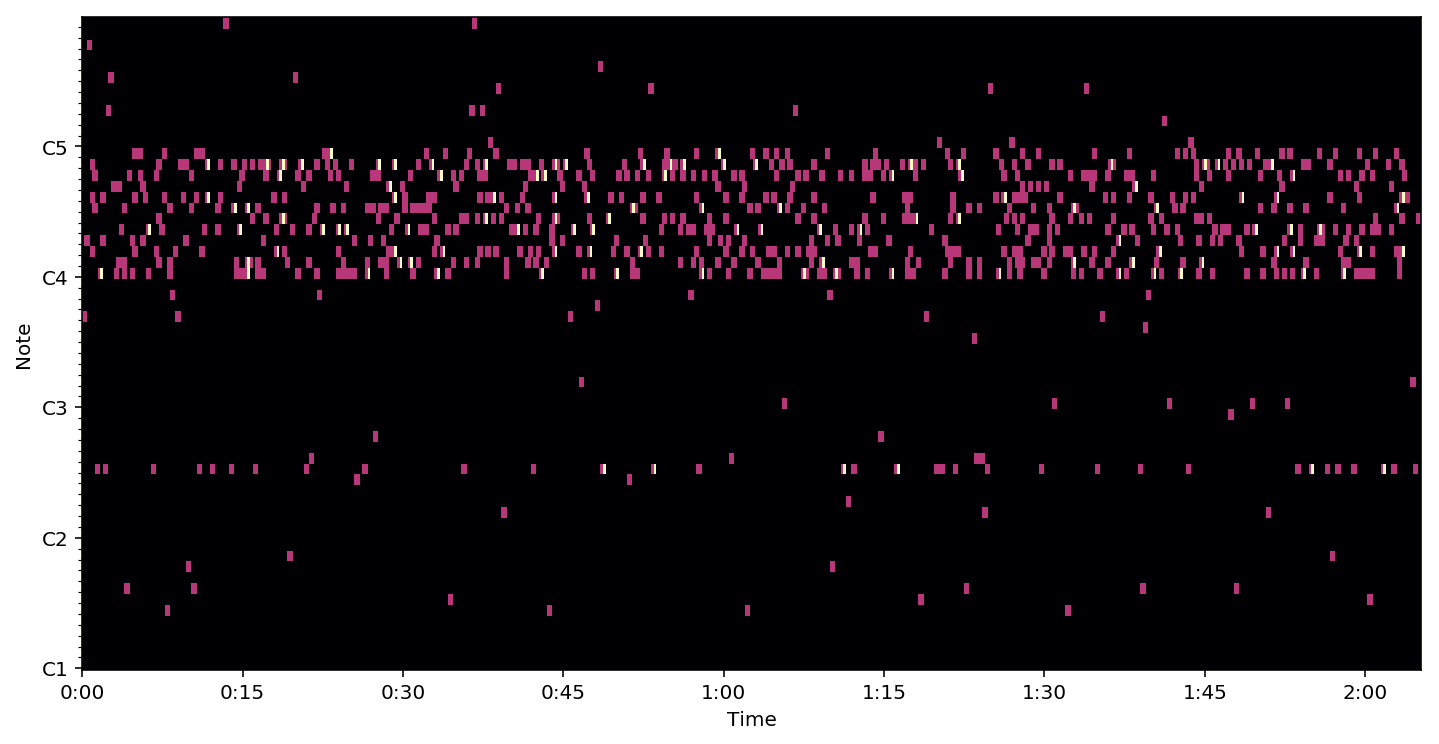

In [22]:

midi_file = '/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/trained_MIDI/201901091937-Jazz-lstm_midi.mid'
instrument_dict,pm = analyze_midi(midi_file)
ipd.Audio(pm.synthesize(fs=fs), rate=rate)


In [25]:
history = pd.read_pickle("/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/output/201901091937-Jazz-history.pkl")

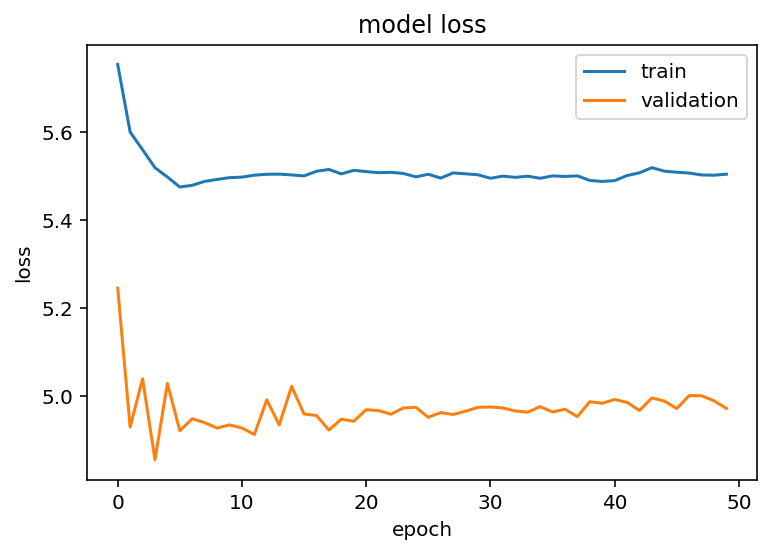

In [28]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

plt.savefig("jazz_loss.png")
plt.show()

In [30]:
output_file = "/Users/anant.a.sharma/Desktop/Darya/AI_for_Music/DATA/output/201901091937-Jazz-output_notes"

In [31]:
output_notes = pd.read_pickle(output_file)

In [32]:
output_notes

[<music21.note.Note G#>,
 <music21.note.Note E->,
 <music21.note.Note A>,
 <music21.chord.Chord G B- D>,
 <music21.chord.Chord F# A>,
 <music21.note.Note F#>,
 <music21.chord.Chord C>,
 <music21.chord.Chord C E- G>,
 <music21.note.Note F#>,
 <music21.note.Note E->,
 <music21.note.Note F#>,
 <music21.chord.Chord G#>,
 <music21.chord.Chord C>,
 <music21.chord.Chord G# C#>,
 <music21.chord.Chord E>,
 <music21.chord.Chord C C# F#>,
 <music21.note.Note G>,
 <music21.note.Note A>,
 <music21.chord.Chord C E->,
 <music21.chord.Chord G B D>,
 <music21.note.Note C#>,
 <music21.chord.Chord A B>,
 <music21.chord.Chord E- G#>,
 <music21.note.Note G>,
 <music21.chord.Chord C E>,
 <music21.chord.Chord E>,
 <music21.note.Note F#>,
 <music21.chord.Chord A D>,
 <music21.chord.Chord B- C# F>,
 <music21.chord.Chord E>,
 <music21.chord.Chord G B>,
 <music21.note.Note F>,
 <music21.chord.Chord C C# F#>,
 <music21.note.Note B->,
 <music21.chord.Chord D>,
 <music21.note.Note G#>,
 <music21.chord.Chord B->,
 <